# Machine Learning - Reducciones de dimensionalidad

## Julio Antonio Fresneda García

Este proyecto va a consistir principalmente en la **comparación de clasificaciones realizadas empleando técnicas de reducción de dimensionalidad**.
Se van a usar las imágenes de caras obtenidas con el método de scikit-learn *fetch_olivetti_faces*.
Con estas imágenes, se van a realizar varias tareas relacionadas con reducciones de dimensionalidad:

   1. Comprimir las imágenes aplicando PCA de manera que se preserve el 95 % de la varianza y mostrar las 8 primeras imágenes originales y descomprimidas. Crear un nuevo dataset con las imágenes comprimidas. ¿Qué número de píxeles quedan al comprimir?
   2. Lo mismo que en 1. usando LDA.
   3.  Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test sea un 20 % del total, tanto para los datos originales como para los comprimidos con PCA y LDA. Repasar la documentación de scikit-learn referida a SVM para ver si es conveniente aplicar transformaciones a los datos.
   4. Realizar una afinación de hiperparámetros para LinearSVC y SVC con kernel ’rbf’ para la clasificación de los datos originales, realizando la búsqueda de parámetros como se comentó en las subsecciones 7.4.1 y 7.4.2 (cambiando SVR por SVC). Usar para el parámetro ’cv’ de GridSearchCV el valor 10. Medir los tiempos en milisegundos de las dos ejecuciones de GridSearchCV. Se recomienda usar multiproceso.
   5. Realizar 4. usando los datos comprimidos mediante PCA.
   6. Realizar 4. usando los datos comprimidos mediante LDA.
   7. Comparar los parámetros resultantes para los mejores estimadores obtenidos en 4., 5. y 6. así como sus accuracies y los tiempos de ejecución totales de las búsquedas y la media de las búsquedas de cada GridSearchCV teniendo en cuenta el número de valores de los parámetros en cada GridSearchCV.








# Pasos previos: Importar y explicar el dataset

Antes de comenzar con las tareas, debemos de cargar el dataset de imágenes que usaremos. Como hemos comentado en el enunciado, usaremos el dataset de *fetch_olivetti_faces* que proporciona scikit-learn.

In [1]:
RANDOM_SEED = 10

In [2]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True, random_state=RANDOM_SEED)

## Descripción del dataset

El propio dataset trae su descripción, la cual explica perfectamente el contenido del mismo.

In [3]:
from IPython.display import Markdown
display(Markdown(faces.DESCR))

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes                                40
    Samples total                         400
    Dimensionality                       4096
    Features            real, between 0 and 1
    =================   =====================

The image is quantized to 256 grey levels and stored as unsigned 8-bit 
integers; the loader will convert these to floating point values on the 
interval [0, 1], which are easier to work with for many algorithms.

The "target" for this database is an integer from 0 to 39 indicating the
identity of the person pictured; however, with only 10 examples per class, this
relatively small dataset is more interesting from an unsupervised or
semi-supervised perspective.

The original dataset consisted of 92 x 112, while the version available here
consists of 64x64 images.

When using these images, please give credit to AT&T Laboratories Cambridge.


## Visualizado de imágenes

Para tener los conceptos un poco más claros, siempre es útil tener información en forma visual, como pueden ser gráficos o imágenes. En este caso, resulta bastante esclarecedor el concepto de pérdida de información a la hora de reducir la dimensionalidad e intentar reconstruir las imágenes originales. 
Es por ello, que vamos a usar una función que pinte 8 de estas imágenes que tome como parámetro. Ésta función la usaremos más adelante.

In [4]:
import matplotlib.pyplot as plt
def plot_gallery(title, images, n_col=4, n_row=2, cmap=plt.cm.gray):
    image_shape = (64, 64)

    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Pasos previos: Pipelines

Una forma muy útil de automatizar operaciones en cadena es mediante pipelines. Los hemos usado en anteriores prácticas, y ya hemos visto que son ampliamente usados.

En el caso de esta práctica, usaremos pipelines: Uno para las imágenes sin reducción de dimensionalidad, otro para imágenes con reducción de dimensionalidad mediante PCA, y otro para imágenes con reducción de dimensionalidad mediante LDA. Ampliaremos información sobre ésto más adelante.

## Transformador personalizado: Image Centering

Algunos algoritmos, como PCA, asumen que el dataset está centrado en el origen. Otros simplemente funcionan mejor. Es por ello que nos será útil tener un transformador que haga esta tarea, para adjuntarla a nuestros pipelines.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class ImageCentering(BaseEstimator, TransformerMixin):

  def __init__(self):  
    pass

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_ = X.copy()
    n_samples, n_features = X_.shape
    
    # global centering
    X_centered = X_ - X_.mean(axis=0)

    # local centering
    X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

    return X_centered

## Composición de pipelines

Como ya adelantamos, usaremos pipelines distintos. El primero, centra las imágenes, y el segundo usa StandardScaler para el escalado.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

PIPE_ImageCentering = Pipeline([('imgcentering', ImageCentering())])
PIPE_StandardScaler = Pipeline([('imgcentering', ImageCentering()), ('standard_scaler', StandardScaler())])

# Tarea 1: Compresión con Principal Component Analysis

**Comprimir las imágenes aplicando PCA de manera que se preserve el 95 % de la varianza y mostrar las 8 primeras imágenes originales y descomprimidas. Crear un nuevo dataset con las imágenes comprimidas. ¿Qué número de píxeles quedan al comprimir?**

El PCA es un algoritmo que, primero identifica el hiperplano que se encuentra más cerca de los datos, o se ajusta más a los datos, y luego proyecta los datos en él, intentando preservar el la máxima varianza posible.

Esta técnica se basa en *mainfold learning*, que parte de la hipótesis *mainfold*, la cual dice que los datasets del mundo real de muchas variables tienden a caer en un hiperplano que se puede explicar con menos variables de las que el dataset tiene. Es por éllo, que si encontramos ese hiperplano teórico, deberíamos reducir la dimensionalidad del dataset con una pérdida mínima de información.

## Imágenes originales

Vamos a mostrar primero ocho imágenes sin comprimir. De ésta forma, podremos apreciar las diferencias. Las veremos sin centrar, y centradas.

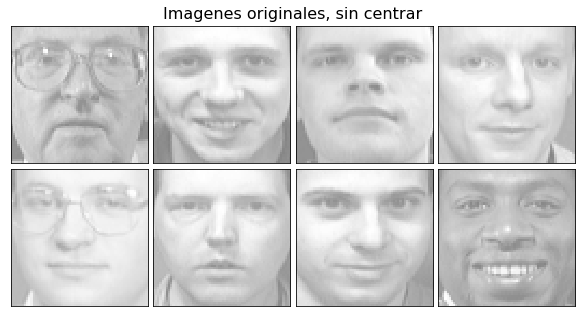

In [7]:
plot_gallery('Imagenes originales, sin centrar', faces.data[:8])

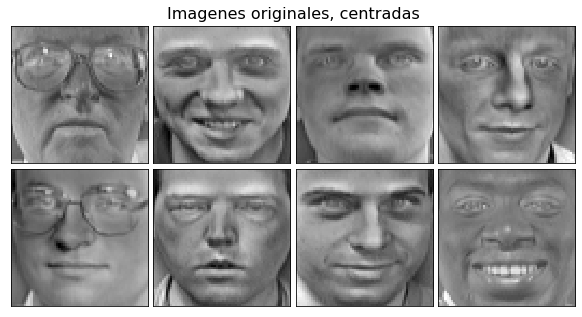

In [8]:
X_centered = PIPE_ImageCentering.fit_transform(faces.data)
plot_gallery('Imagenes originales, centradas', X_centered[:8])

Hemos visto algunas imágenes, pero no hemos dicho nada de dimensionalidad. ¿Cuántos píxeles tiene cada imagen?

In [9]:
faces.data.shape

(400, 4096)

Al ser una imagen 64x64, tenemos 4096 píxeles, es decir, 4096 variables explicativas.

## Usando Principal Component Analysis

Primero, vamos a reducir la dimensionalidad del dataset. Usaremos la librería de scikit-learn. Como nos indican en el enunciado, buscamos que se preserve, como mínimo, el 95% de la varianza.

In [10]:
from sklearn.decomposition import PCA
# Cargamos el objeto PCA
pca = PCA(n_components = 0.95)

# Centramos y escalamos
X_centered = PIPE_StandardScaler.fit_transform(faces.data)

# Obtenemos el dataset con dimensionalidad reducida
X_PCA = pca.fit_transform(X_centered)

Vamos a ver cuantas dimensiones tenemos después de usar PCA

In [11]:
X_PCA.shape

(400, 146)

146 variables, es decir, **146 píxeles**, explicando el 95% del dataset original. Vamos a volver a descomprimir, y comparamos visualmente, para apreciear la pérdida de información. Usaremos la transformación inversa.

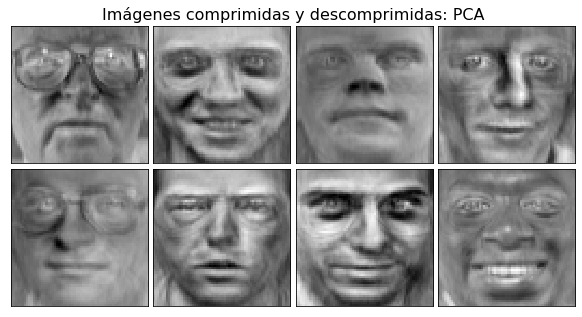

In [12]:
X_PCA_desc = pca.inverse_transform(X_PCA)
plot_gallery("Imágenes comprimidas y descomprimidas: PCA", X_PCA_desc[:8])

Podemos apreciar que recuperamos imágenes muy parecidas a las originales, sin casi pérdida de información.

# Tarea 2: Compresión con Linear Discriminant Analysis

**Comprimir las imágenes aplicando LDA de manera que se preserve el 95 % de la varianza y mostrar las 8 primeras imágenes originales y descomprimidas. Crear un nuevo dataset con las imágenes comprimidas. ¿Qué número de píxeles quedan al comprimir?**

Primero, vamos a reducir la dimensionalidad del dataset. Usaremos la librería de scikit-learn. En este caso, no podemos asegurar un 95% de varianza ya que no lo permite el constructor del objeto LDA. Es por ello que calcularemos el número de componentes a mano.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

lda = LinearDiscriminantAnalysis()
lda.fit(X_centered, faces.target)
cumsum = np.cumsum(lda.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

29

Parece ser que 29 es el número de componentes mínimo que preservan este 95% de varianza. Sabiendo ésto, vamos a obtener el dataset comprimido.

In [14]:
lda = LinearDiscriminantAnalysis(n_components = 29)
X_LDA = lda.fit(X_centered,faces.target).transform(X_centered)
X_LDA.shape

(400, 29)

Listo, ya tenemos nuestro dataset con dimensionalidad reducida. Cada imagen se ha reducido a **29 pixeles**.

Ya que no podemos obtener la inversa de forma nativa para ver las imágenes reconstruidas, vamos a construir una función que nos devuelva la pseudo-inversa. La fuente está referenciada en la bibliografía.

In [15]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

def inverse_transform(lda, x):
   
    check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

    inv = np.linalg.pinv(lda.scalings_)

    x = check_array(x)
    if lda.solver == 'svd':
        x_back = np.dot(x, inv) + lda.xbar_
    elif lda.solver == 'eigen':
        x_back = np.dot(x, inv)

    return x_back

Puesto que, para que funcione la inversa, debemos tener la dimensionalidad igual a la longitud de atributos de scalings, vamos a llenar con ceros.

In [16]:
(lda.scalings_.shape[1])

39

In [17]:
X_LDA_rec = X_LDA.copy()

In [18]:
X_LDA_rec_ = []
for a in X_LDA_rec:
    while(len(a) < lda.scalings_.shape[1]):
        a = np.append(a,0)
    X_LDA_rec_.append(a)
    
X_LDA_rec_ = np.asarray(X_LDA_rec_)

Ya podemos obtener la información inversa.

In [19]:
Xb = inverse_transform(lda, X_LDA_rec_)

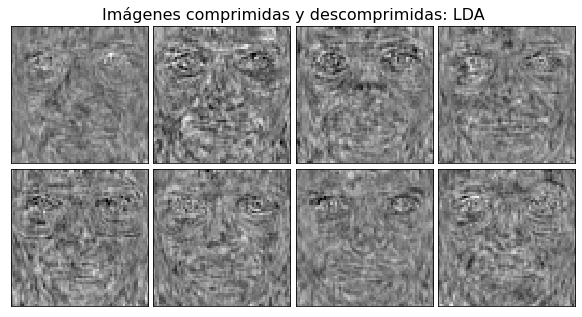

In [20]:
plot_gallery("Imágenes comprimidas y descomprimidas: LDA", Xb[:8])

En este caso en particular no sabría decir si realmente se ha conservado el 95% de información o hemos hecho algo mal. Quizás sí que está la información, pero no podemos apreciarla con el ojo humano.

# Tarea 3: División en train y test

**Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test sea un 20 % del total, tanto para los datos originales como para los comprimidos con PCA y LDA. Repasar la documentación de scikit-learn referida a SVM para ver si es conveniente aplicar transformaciones a los datos.**

Usaremos la función *train_test_split*, proporcionada por la librería de scikit-learn. Puesto que usamos misma semilla para la aleatoreidad, el orden es el mismo en todas las divisiones.

In [21]:
from sklearn.model_selection import train_test_split

# Sin comprimir
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, random_state=RANDOM_SEED)

# Compresión PCA
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, faces.target, test_size=0.2, random_state=RANDOM_SEED)

# Compresión LDA
X_LDA_train, X_LDA_test, y_LDA_train, y_LDA_test = train_test_split(X_LDA, faces.target, test_size=0.2, random_state=RANDOM_SEED)


Puesto que en las próximas tareas vamos a usar algoritmos de clasificación basados en Support Vector Machines, debemos hacer alguna transformación. En el caso de la información sin compresión, debemos centrar las imágenes y escalar. En los otros dos casos (PCA y LDA), ya hemos hecho estas tareas, por tanto nos ahorramos este paso.

In [22]:
X_train = PIPE_StandardScaler.fit_transform(X_train)
X_test = PIPE_StandardScaler.fit_transform(X_test)

# Pasos previos a las tareas siguientes: Clase para entrenar

Las siguientes tareas van a ser bastante repetitivas. Para no hacer este trabajo demasiado redundante y con código repetitivo, vamos a definir una clase que haga todo por nosotros:

   1. Hace una primera búsqueda de hiperparámetros usando GridSearchCV
   2. Hace una segunda búsqueda de hiperparámetros usando GridSearchCV
   3. Entrena el modelo con los mejores hiperparámetros encontrados
   4. Evalúa con el dataset de test

In [23]:
from sklearn.model_selection import GridSearchCV
import time
import math

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

class CompleteTrainWithGridSearch:
    def __init__(self, X_train, y_train, X_test, y_test, model):
        # Inicialización
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        
        self.X_test = X_test.copy()
        self.y_test = y_test.copy()
        
        self.model = model
        
    def startTraining(self):
        # Pasos a seguir
        self.firstSearch()
        self.secondSearch()
        self.trainModel()
        self.evaluateModel()
        
    def firstSearch(self):
        # Primera búsqueda de C y gamma
        print("First Search")
        gamma = []
        C = []
        for i in range(-7,15):
            if(i%2==0):
                C.append(pow(2,i))
                gamma.append(pow(2,-i))
        
        self.gridSearch(gamma, C)
        
    def secondSearch(self):
        # Segunda búsqueda de C y gamma
        print("Second Search")
        gamma = []
        C = []
        for i in range(int(self.bestC-1),int(self.bestC+2)):
            for j in range(0,4):
                C.append(round(pow(2,i + j*0.25),2))
        
        if(self.model == 'SVC'):
            for i in range(int(self.bestgamma-1),int(self.bestgamma+2)):
                for j in range(0,4):
                    gamma.append(round(pow(2,i + j*0.25),10))
                
        self.gridSearch(gamma, C, printBest = True)
        
    def gridSearch(self, gamma, C, printBest = False):
        # Búsqueda de C y gamma usando gridSearch
        start_time = time.time()

        
        if(self.model == 'SVC'):
            grid_params = {'gamma':gamma, 'C':C}
            gs = GridSearchCV(SVC(), grid_params, verbose = 1, cv = 10, n_jobs = -1)
        elif(self.model == 'LinearSVC'):
            grid_params = {'C':C}
            gs = GridSearchCV(LinearSVC(), grid_params, verbose = 1, cv = 10, n_jobs = -1)
        gs_results = gs.fit(self.X_train, self.y_train)

        print("--- %s seconds ---" % (time.time() - start_time))
        
        self.bestC = math.log(gs_results.best_params_['C'],2)
        if(self.model == 'SVC'):
            self.bestgamma = math.log(gs_results.best_params_['gamma'],2)
        
        
        if(printBest):
            print("Best score:")
            print(gs_results.best_score_)
            print("Best estimator:")
            print(gs_results.best_estimator_)
            print("Best params:")
            print(gs_results.best_params_)
            
    def trainModel(self):
        # Entrenamos el modelo completo
        print("Training full model")
        if(self.model == 'SVC'):
            self.model = SVC(C=pow(2,self.bestC), gamma=pow(2,self.bestgamma))
        elif(self.model == 'LinearSVC'):
            self.model = LinearSVC(C=pow(2,self.bestC))
            
        self.model.fit(self.X_train, self.y_train)
        
        
    # Pinta la matriz de confusion
    def evaluateModel(self):
        print("Evaluating with test")
        y_pred = self.model.predict(self.X_test)

        # Confusion Matrix
        #cmp = ConfusionMatrixDisplay.from_predictions(y, y_pred)
        #fig, ax = plt.subplots(figsize=(15,15))
        #cmp.plot(ax=ax)

        # Accuracy
        print("Accuracy:")
        print(accuracy_score(self.y_test, y_pred))

        # Recall
        #print("Recall:")
        #print(recall_score(self.y_test, y_pred, average=None))

        # Precision
        print("Precision:")
        print(precision_score(self.y_test, y_pred, average=None))

        # F1 Score
        print("F1 Score:")
        print(f1_score(self.y_test, y_pred, average=None))
        

# Tarea 4: Clasificación de los datos originales

**Realizar una afinación de hiperparámetros para LinearSVC y SVC con kernel ’rbf’ para la clasificación de los datos originales, realizando la búsqueda de parámetros como se comentó en las subsecciones 7.4.1 y 7.4.2 (cambiando SVR por SVC). Usar para el parámetro ’cv’ de GridSearchCV el valor 10. Medir los tiempos en milisegundos de las dos ejecuciones de GridSearchCV. Se recomienda usar multiproceso.**

Gracias a la clase anteriormente definida, podemos cumplir esta tarea en unas pocas líneas.

## LinearSVC

In [24]:
cts = CompleteTrainWithGridSearch(X_train, y_train, X_test, y_test, model = 'LinearSVC')
cts.startTraining()

First Search
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 1516.5606124401093 seconds ---
Second Search
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 1254.5398118495941 seconds ---
Best score:
0.95625
Best estimator:
LinearSVC(C=0.01)
Best params:
{'C': 0.01}
Training full model
Evaluating with test
Accuracy:
0.925
Precision:
[0.  0.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.
 1.  1.  0.5 1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.
 1.  1. ]
F1 Score:
[0.         0.         0.8        1.         0.5        1.
 1.         1.         1.         1.         1.         1.
 0.5        0.         1.         1.         1.         1.
 1.         1.         0.66666667 1.         1.         1.
 0.66666667 1.         1.         1.         1.         1.
 1.         1.         0.85714286 0.66666667 1.         1.
 1.         1.        ]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVC

In [25]:
cts = CompleteTrainWithGridSearch(X_train, y_train, X_test, y_test, model = 'SVC')
cts.startTraining()

First Search
Fitting 10 folds for each of 121 candidates, totalling 1210 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 59.47594666481018 seconds ---
Second Search
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 70.21676921844482 seconds ---
Best score:
0.959375
Best estimator:
SVC(C=9.51, gamma=3.62917e-05)
Best params:
{'C': 9.51, 'gamma': 3.62917e-05}
Training full model
Evaluating with test
Accuracy:
0.9375
Precision:
[1.   1.   0.75 0.5  0.5  1.   0.5  1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   0.5  1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.  ]
F1 Score:
[1.         0.8        0.85714286 0.5        0.66666667 1.
 0.66666667 1.         0.66666667 1.         1.         0.8
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.66666667 1.
 1.         1.         1.         1.         1.         1.
 0.85714286 1.         1.         1.         1.         1.        ]


Podemos observar que se obtienen unos scores excepcionales, tanto en el propio train como el test. Pero, si ya obtenemos unos resultados así de buenos, ¿para qué comprimir, si ya tenemos resultados excelentes, y además perdemos información? Vamos a verlo.

# Tarea 5: Clasificación de los datos comprimidos con PCA

**Seguir los pasos de la tarea 4, pero usando los datos comprimidos con PCA.**

## LinearSVC

In [26]:
cts = CompleteTrainWithGridSearch(X_PCA_train, y_PCA_train, X_PCA_test, y_PCA_test, model = 'LinearSVC')
cts.startTraining()

First Search
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 37.84230947494507 seconds ---
Second Search
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--- 61.492920875549316 seconds ---
Best score:
0.94375
Best estimator:
LinearSVC(C=0.01)
Best params:
{'C': 0.01}
Training full model
Evaluating with test
Accuracy:
0.925
Precision:
[1.         0.66666667 1.         0.         0.5        1.
 0.5        1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.5        1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.66666667]
F1 Score:
[1.         0.66666667 1.         0.         0.66666667 1.
 0.66666667 1.         0.66666667 1.         1.         0.8
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.66666667 1.
 1.         1.         1.         1.         1.         1.
 0.85714286 1.         1.         1.         1.         0.8       ]


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## SVC

In [27]:
cts = CompleteTrainWithGridSearch(X_PCA_train, y_PCA_train, X_PCA_test, y_PCA_test, model = 'SVC')
cts.startTraining()

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


First Search
Fitting 10 folds for each of 121 candidates, totalling 1210 fits
--- 4.5209033489227295 seconds ---
Second Search
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 5.101607322692871 seconds ---
Best score:
0.959375
Best estimator:
SVC(C=8.0, gamma=5.13242e-05)
Best params:
{'C': 8.0, 'gamma': 5.13242e-05}
Training full model
Evaluating with test
Accuracy:
0.975
Precision:
[1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
F1 Score:
[1.         0.8        1.         1.         1.         1.
 0.66666667 1.         0.66666667 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.66666667 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


# Tarea 6: Clasificación de los datos comprimidos con LDA

**Seguir los pasos de la tarea 4, pero usando los datos comprimidos con LDA.**

## LinearSVC

In [28]:
cts = CompleteTrainWithGridSearch(X_LDA_train, y_LDA_train, X_LDA_test, y_LDA_test, model = 'LinearSVC')
cts.startTraining()

First Search
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 2.5226786136627197 seconds ---
Second Search
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 2.646900177001953 seconds ---
Best score:
1.0
Best estimator:
LinearSVC(C=0.01)
Best params:
{'C': 0.01}
Training full model
Evaluating with test
Accuracy:
1.0
Precision:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 Score:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## SVC

In [29]:
cts = CompleteTrainWithGridSearch(X_LDA_train, y_LDA_train, X_LDA_test, y_LDA_test, model = 'SVC')
cts.startTraining()

First Search
Fitting 10 folds for each of 121 candidates, totalling 1210 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 3.1347897052764893 seconds ---
Second Search
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


--- 3.9903392791748047 seconds ---
Best score:
1.0
Best estimator:
SVC(C=0.5, gamma=0.0078125)
Best params:
{'C': 0.5, 'gamma': 0.0078125}
Training full model
Evaluating with test
Accuracy:
1.0
Precision:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1 Score:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Tarea 7: Evaluación de resultados

**Comparar los parámetros resultantes para los mejores estimadores obtenidos en 4., 5. y 6. así como sus accuracies y los tiempos de ejecución totales de las búsquedas y la media de las búsquedas de cada GridSearchCV teniendo en cuenta el número de valores de los parámetros en cada GridSearchCV.**

Ya tenemos los resultados de cada modelo. Vamos a guardarlos en un dataframe a mano, para comparar gráficamente el desempeño de cada tipo de compresión.

In [33]:
import pandas as pd
results = pd.DataFrame({
    'Compression':['No compression','No compression','PCA','PCA','LDA','LDA'],
    'Learning Algorithm':['No compression: LinearSVC', 'No compression: SVC', 'PCA: LinearSVC', 'PCA: SVC', 'LDA: LinearSVC', 'LDA: SVC'],
    'First Search Time':[1516.56, 59.47, 37.84, 4.52, 2.52, 3.13],
    'Second Search Time':[1254.53, 70.21, 61.49, 5.10, 2.64, 3.99],
    'Test Accuracy':[0.925, 0.9375, 0.925, 0.975, 1, 1]
})

results['Total Search Time'] = results['First Search Time'] + results['Second Search Time']
results['First Search Each Training Time'] = np.where(results['Learning Algorithm'] == 'SVC', results['First Search Time']/121, results['First Search Time']/11)
results['Second Search Each Training Time'] = np.where(results['Learning Algorithm'] == 'SVC', results['Second Search Time']/144, results['Second Search Time']/12)
results['Total Search Each Training Time'] = results['First Search Each Training Time'] + results['Second Search Each Training Time']


results

,Compression,Learning Algorithm,First Search Time,Second Search Time,Test Accuracy,Total Search Time,First Search Each Training Time,Second Search Each Training Time,Total Search Each Training Time
0,No compression,No compression: LinearSVC,1516.56,1254.53,0.9250,2771.09,137.869091,104.544167,242.413258
1,No compression,No compression: SVC,59.47,70.21,0.9375,129.68,5.406364,5.850833,11.257197
2,PCA,PCA: LinearSVC,37.84,61.49,0.9250,99.33,3.440000,5.124167,8.564167
3,PCA,PCA: SVC,4.52,5.10,0.9750,9.62,0.410909,0.425000,0.835909
4,LDA,LDA: LinearSVC,2.52,2.64,1.0000,5.16,0.229091,0.220000,0.449091
5,LDA,LDA: SVC,3.13,3.99,1.0000,7.12,0.284545,0.332500,0.617045


### Comparación de tiempos

<AxesSubplot:xlabel='Learning Algorithm'>

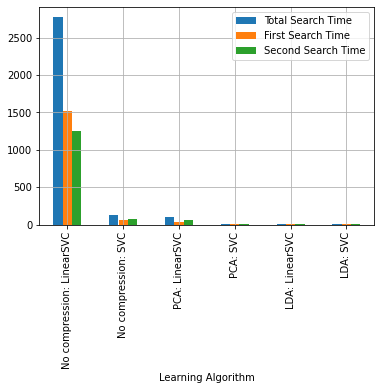

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# a simple line plot
results.plot(kind='bar',x='Learning Algorithm',y=['Total Search Time', 'First Search Time', 'Second Search Time'], grid=True)

Podemos observar una diferencia abrumadora: Sin compresión, los algoritmos tardan, aproximadamente, unas 20 veces más en cada entrenamiento. Ésto es de esperar, puesto que tienen que entrenar con 64x64 variables, mientras que con los datasets comprimidos, entrenan con poco más de 100.

Mientras que con LinearSVC, sin compresión tarda unos 20-30 minutos en completar cada búsqueda de hiperparámetros, con compresión ronda el minuto. Por búsqueda, pasa de unos dos minutos aproximadamente, a unos 5 segundos.

Para SVC, los tiempos mejoran mucho respecto a LinearSVC. Sin embargo, las distancias entre datasets sin comprimir y comprimidos se mantienen: Para cada búsqueda de gridsearch, pasa de un minuto aproximadamente, a unos 5 segundos. Cada entrenamiento pasa de durar 5 segundos, a medio segundo.

Vemos que, en cuanto a tiempos, merece **mucho** la pena usar técnicas de compresión como PCA o LDA. Pero, ¿qué pasa con la calidad de los modelos? ¿Funcionan igual de bien, o la pérdida de información nos lastra las puntuaciones? 

### Comparación de scores

<AxesSubplot:xlabel='Learning Algorithm'>

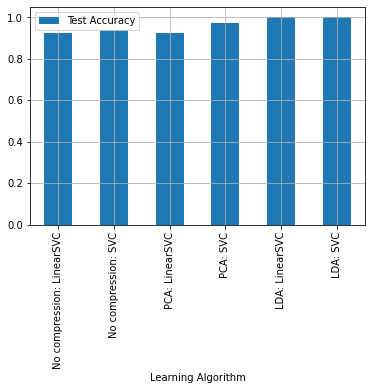

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# a simple line plot
results.plot(kind='bar',x='Learning Algorithm',y='Test Accuracy', grid=True)

Si bien sin comprimir se han obtenido unas puntuaciones muy buenas, con el dataset comprimido las puntuaciones han sido incluso mejores! Ésto se puede deber a que al algoritmo le cuesta mucho menos trabajo entrenar con pocas variables, y suple esa pérdida de información al comprimir (recordemos que en PCA asegurábamos una varianza del 95%), con una mayor facilidad para ajustar el modelo.

Con LDA, de hecho, hemos encontrado un modelo teóricamente perfecto, con un 100% de aciertos en el test.

Hay que tener en cuenta también que tenemos sólo 320 entradas para entrenar el modelo, bastante pocas para tantas variables a entrenar.

En conclusión, usar técnicas de compresión como puede ser PCA o LDA, no sólo nos ayuda en cuanto a tiempos de entrenamiento, si no que incluso puede ayudarnos en cuanto a calidad del modelo, ya que hay menos variables a ajustar, a pesar de la pequeña pérdida de información.

# Bibliografía

   * Transformación inversa de LDA: https://stackoverflow.com/questions/42957962/linear-discriminant-analysis-inverse-transform
   * Documentación respecto a Principal Component Analysis: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
   * Documentación respecto a Latent Dirichlet Allocation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation
   * Documentación respecto a SVMs: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
   * Ejemplos de transformadores personalizados para pipelines: https://github.com/HCGrit/MachineLearning-iamJustAStudent/blob/master/PipelineFoundation/Pipeline_Experiment.ipynb
   * Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow - Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition (2019)